# Project 2: Mini deep-learning framework

You should be able to copy paste everything here to test.py

In [1]:
#!/usr/bin/env python3
""" File to solve the second miniproject which is the design of a framework """

import math
import matplotlib
import matplotlib.pyplot as plt

import torch
from torch import empty

__author__ = 'Eugène Lemaitre, Natalie Bolón Brun, Louis Munier'
__version__ = '0.1'

torch.set_grad_enabled(False)

In [2]:
from Linear import Linear
from Activation import Tanh, Relu, Sigmoid
from Loss import LossMSE, CrossEntropy
from Optimizers import Optimizers, Sgd, DecreaseSGD
from Sequential import Sequential

In [3]:
def compute_number_error(output_one_hot, target_one_hot):
    output = output_one_hot.argmax(dim=1)
    target = target_one_hot.argmax(dim=1)
    nb_of_error = (output != target).sum()
    return nb_of_error

## Data generation

In [4]:
def generate_disc_set(nb):
    X = empty(nb,2).uniform_(0,1)
    Y = empty(X.size())
    
    Y[:,0] = ((X - 0.5).norm(dim=1)  >  math.sqrt(1/(2*math.pi))).type(torch.LongTensor)
    Y[:,1] = ((X - 0.5).norm(dim=1)  <=  math.sqrt(1/(2*math.pi))).type(torch.LongTensor)
    
    return X, Y

def plot_disc(data_in, data_target, title):
    plt.scatter(data_in[(data_target[:,1]==1),0] ,data_in[(data_target[:,1]==1),1], color = "c", s=20)
    plt.scatter(data_in[(data_target[:,1]==0),0] ,data_in[(data_target[:,1]==0),1], color = "g", s=20)
    plt.title(title)
    plt.legend(["1", "0"] )
    plt.show()
    
def plot_result(data_in, data_target, data_class):
    one_id_as_one = torch.mul( (data_target[:,1]==1), (data_class ==1 ))
    one_id_as_zero = torch.mul( (data_target[:,1]==1), (data_class ==0 ))
    zero_id_as_one = torch.mul( (data_target[:,1]==0), (data_class ==1 ))
    zero_id_as_zero = torch.mul( (data_target[:,1]==0), (data_class ==0 ))
    
    plt.scatter(data_in[one_id_as_one,0] ,data_in[one_id_as_one,1], color = "c", s=20)
    plt.scatter(data_in[zero_id_as_zero,0] ,data_in[zero_id_as_zero,1], color = "g", s=20)
    plt.scatter(data_in[one_id_as_zero,0] ,data_in[one_id_as_zero,1], color = "r", s=20)
    plt.scatter(data_in[zero_id_as_one,0] ,data_in[zero_id_as_one,1], color = "y", s=20)
    
    plt.title("Result on train data")
    plt.legend(["1 id as 1", "0 id as 0", "1 id as 0", "0 id as 1"] )
    plt.show()
    
def plot_loss(epochs, loss):
    plt.plot(epochs, loss)
    plt.title("Loss")

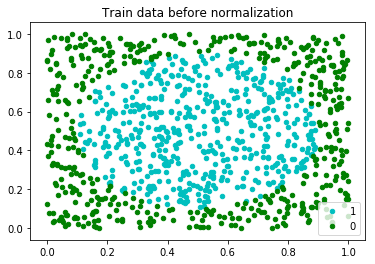

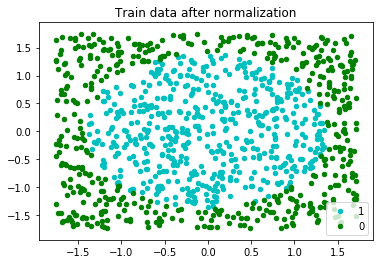

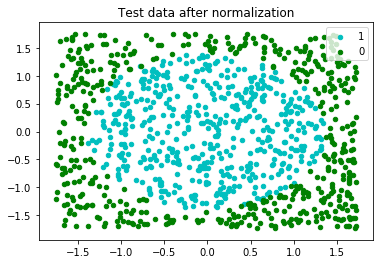

In [5]:
Sample_number = 1000
train_input, train_target = generate_disc_set(Sample_number)
test_input, test_target = generate_disc_set(Sample_number)


plot_disc(train_input, train_target, "Train data before normalization")

mu, std = train_input.mean(0), train_input.std(0)
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std)

plot_disc(train_input, train_target, "Train data after normalization")
plot_disc(test_input, test_target, "Test data after normalization")

## Model 1: No dropout, constant learning rate

In [6]:
hidden_nb = 25

linear_1 = Linear(2, hidden_nb)
relu_1 = Relu()
linear_2 = Linear(hidden_nb, hidden_nb)
relu_2 = Relu()
linear_3 = Linear(hidden_nb, hidden_nb)
relu_3 = Relu()
linear_4 = Linear(hidden_nb, 2)
loss = CrossEntropy()

model_1 = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=CrossEntropy()) 
       
std = 0.1
eta = 3e-1
batch_size = 200
epochs_number = 1000

my_loss_1 = []

model_1.normalize_parameters(mean=0, std=std)
optimizer = Sgd()

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model_1.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model_1.compute_loss(output, train_target.narrow(0, b, batch_size))
        model_1.backward()
        
        optimizer(model_1.sequence, eta=eta)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
    my_loss_1.append(loss_value.item())

0 :  0.6920922994613647
50 :  0.2970668077468872
100 :  0.1528131067752838
150 :  0.06538543850183487
200 :  0.05059264972805977
250 :  0.0486767552793026
300 :  0.04478149488568306
350 :  0.04447326436638832
400 :  0.039531249552965164
450 :  0.03785094991326332
500 :  0.032365720719099045
550 :  0.030878296121954918
600 :  0.028077391907572746
650 :  0.030867919325828552
700 :  0.022419432178139687
750 :  0.02228393591940403
800 :  0.02155151404440403
850 :  0.019536131992936134
900 :  0.019496459513902664
950 :  0.020057372748851776



 
Loss:  0.05066113546490669
Number of errors:  18

 


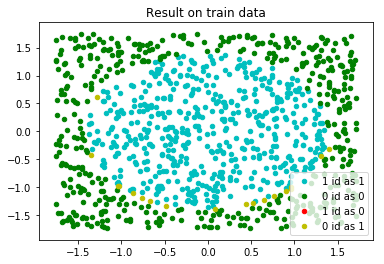

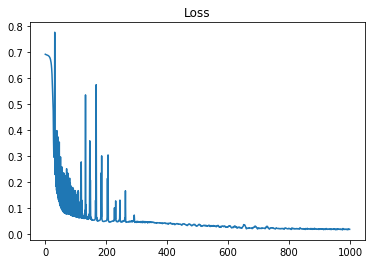

In [7]:
output = model_1.forward(train_input)
l = model_1.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")


id_class_train = output.argmax(dim=1)
plot_result(train_input, train_target, id_class_train)
plot_loss(range(0, epochs_number), my_loss_1)


 
Loss:  0.07232227176427841
Number of errors:  29

 


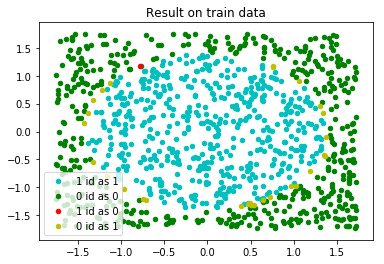

In [8]:
output = model_1.forward(test_input)
l = model_1.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")


id_class_test = output.argmax(dim=1)
plot_result(test_input, test_target, id_class_test)


## Model 2: No dropout, deacreasing learning rate

In [10]:
hidden_nb = 25

linear_1 = Linear(2, hidden_nb)
relu_1 = Relu()
linear_2 = Linear(hidden_nb, hidden_nb)
relu_2 = Relu()
linear_3 = Linear(hidden_nb, hidden_nb)
relu_3 = Relu()
linear_4 = Linear(hidden_nb, 2)
loss = CrossEntropy()

model_2 = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=CrossEntropy()) 
       
std = 0.1
eta = 3e-1
batch_size = 200
epochs_number = 1000

my_loss_2 = []

model_2.normalize_parameters(mean=0, std=std)
optimizer = DecreaseSGD()

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model_2.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model_2.compute_loss(output, train_target.narrow(0, b, batch_size))
        model_2.backward()
        
        optimizer(epochs, model_2.sequence, eta=eta)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
    my_loss_2.append(loss_value.item())

0 :  0.6918668746948242
50 :  0.5647252202033997
100 :  0.2203948199748993
150 :  0.14539200067520142
200 :  0.11877471953630447
250 :  0.10547393560409546
300 :  0.0951315313577652
350 :  0.08758910745382309
400 :  0.08212493360042572
450 :  0.07784545421600342
500 :  0.07440673559904099
550 :  0.07152160257101059
600 :  0.06905364990234375
650 :  0.06704498082399368
700 :  0.06528869271278381
750 :  0.0637383982539177
800 :  0.06236358359456062
850 :  0.0611502043902874
900 :  0.06006225571036339
950 :  0.05903259292244911



 
Loss:  0.05226806923747063
Number of errors:  13

 


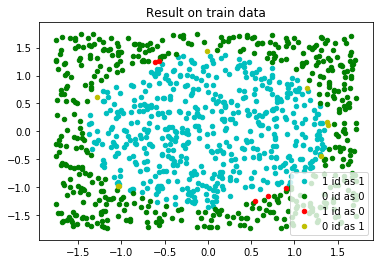

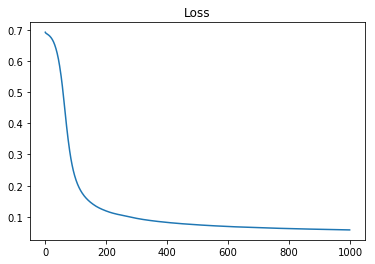

In [11]:
output = model_2.forward(train_input)
l = model_2.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")


id_class_train = output.argmax(dim=1)
plot_result(train_input, train_target, id_class_train)
plot_loss(range(0, epochs_number), my_loss_2)


 
Loss:  0.059238772839307785
Number of errors:  21

 


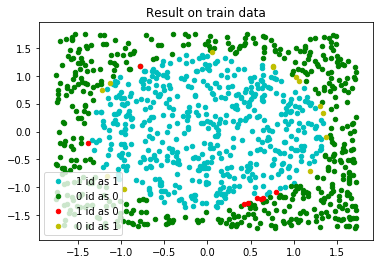

In [12]:
output = model_2.forward(test_input)
l = model_2.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")


id_class_test = output.argmax(dim=1)
plot_result(test_input, test_target, id_class_test)


## Model 3: Dropout, constant learning rate

In [13]:
hidden_nb = 25
dropout = 0.25

linear_1 = Linear(2, hidden_nb)
relu_1 = Relu()
linear_2 = Linear(hidden_nb, hidden_nb, dropout=dropout)
relu_2 = Relu()
linear_3 = Linear(hidden_nb, hidden_nb, dropout=dropout)
relu_3 = Relu()
linear_4 = Linear(hidden_nb, 2)
loss = CrossEntropy()

model_3 = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=CrossEntropy()) 
       
std = 0.1
eta = 3e-1
batch_size = 200
epochs_number = 1000

my_loss_3 = []

model_3.normalize_parameters(mean=0, std=std)
optimizer = Sgd()

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model_3.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model_3.compute_loss(output, train_target.narrow(0, b, batch_size))
        model_3.backward()
        
        optimizer(model_3.sequence, eta=eta)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
    my_loss_3.append(loss_value.item())

0 :  0.6951945424079895
50 :  0.2891680896282196
100 :  0.10123015940189362
150 :  0.07422485202550888
200 :  0.13623046875
250 :  0.043458860367536545
300 :  0.08404235541820526
350 :  0.05232482776045799
400 :  0.05533691123127937
450 :  0.04871948063373566
500 :  0.07151366770267487
550 :  0.04415282979607582
600 :  0.1619134545326233
650 :  0.021610107272863388
700 :  0.05658630281686783
750 :  0.08151000738143921
800 :  0.0254064928740263
850 :  0.03515380620956421
900 :  0.04423828050494194
950 :  0.04442993178963661



 
Loss:  0.021208984777331352
Number of errors:  8

 


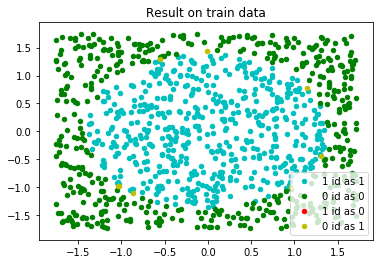

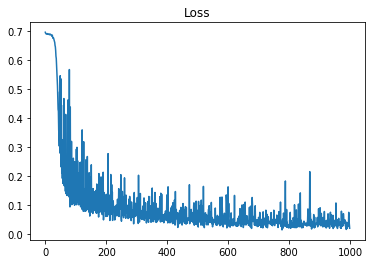

In [14]:
output = model_3.forward(train_input)
l = model_3.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")


id_class_train = output.argmax(dim=1)
plot_result(train_input, train_target, id_class_train)
plot_loss(range(0, epochs_number), my_loss_3)


 
Loss:  0.054584965109825134
Number of errors:  21

 


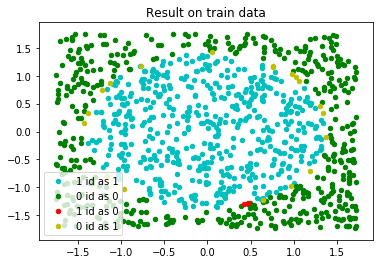

In [15]:
output = model_3.forward(test_input)
l = model_3.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")


id_class_test = output.argmax(dim=1)
plot_result(test_input, test_target, id_class_test)


## Model 4: Same as 1 with tanh

In [18]:
hidden_nb = 25

linear_1 = Linear(2, hidden_nb)
relu_1 = Tanh()
linear_2 = Linear(hidden_nb, hidden_nb)
relu_2 = Tanh()
linear_3 = Linear(hidden_nb, hidden_nb)
relu_3 = Tanh()
linear_4 = Linear(hidden_nb, 2)
loss = CrossEntropy()

model_4 = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=CrossEntropy()) 
       
std = 0.1
eta = 3e-1
batch_size = 200
epochs_number = 1000

my_loss_4 = []

model_4.normalize_parameters(mean=0, std=std)
optimizer = Sgd()

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model_4.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model_4.compute_loss(output, train_target.narrow(0, b, batch_size))
        model_4.backward()
        
        optimizer(model_4.sequence, eta=eta)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
    my_loss_4.append(loss_value.item())

0 :  0.6906885504722595
50 :  0.689538836479187
100 :  0.6769251227378845
150 :  0.6326353549957275
200 :  0.2210676521062851
250 :  0.14314208924770355
300 :  0.13186034560203552
350 :  0.12961243093013763
400 :  0.12671568989753723
450 :  0.11942809820175171
500 :  0.10845062136650085
550 :  0.10105102509260178
600 :  0.09608794748783112
650 :  0.09065978974103928
700 :  0.08692169189453125
750 :  0.08375243842601776
800 :  0.08085601776838303
850 :  0.07804320752620697
900 :  0.07525024563074112
950 :  0.04809020832180977



 
Loss:  0.05066113546490669
Number of errors:  18

 


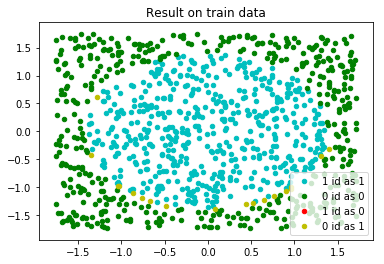

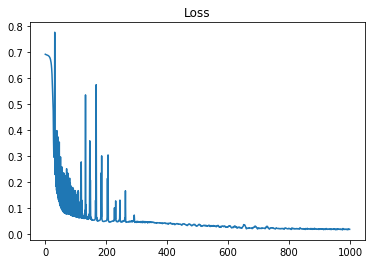

In [7]:
output = model_4.forward(train_input)
l = model_4.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")


id_class_train = output.argmax(dim=1)
plot_result(train_input, train_target, id_class_train)
plot_loss(range(0, epochs_number), my_loss_4)


 
Loss:  0.06450928002595901
Number of errors:  27

 


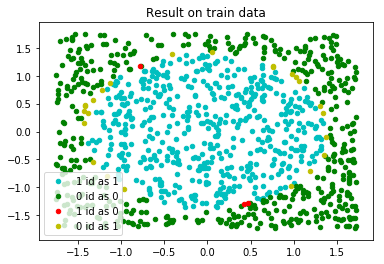

In [19]:
output = model_4.forward(test_input)
l = model_4.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")


id_class_test = output.argmax(dim=1)
plot_result(test_input, test_target, id_class_test)


## Model 5: Same as 1 with Sigmoid

In [30]:
hidden_nb = 25
p_lambda = 1

linear_1 = Linear(2, hidden_nb)
relu_1 = Sigmoid(p_lambda)
linear_2 = Linear(hidden_nb, hidden_nb)
relu_2 = Sigmoid(p_lambda)
linear_3 = Linear(hidden_nb, hidden_nb)
relu_3 = Sigmoid(p_lambda)
linear_4 = Linear(hidden_nb, 2)
loss = CrossEntropy()

model_5 = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=CrossEntropy()) 
       
std = 0.1
eta = 3e-1
batch_size = 200
epochs_number = 1000

my_loss_5 = []

model_5.normalize_parameters(mean=0, std=std)
optimizer = Sgd()

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model_5.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model_5.compute_loss(output, train_target.narrow(0, b, batch_size))
        model_5.backward()
        
        optimizer(model_5.sequence, eta=eta)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
    my_loss_5.append(loss_value.item())

0 :  0.6913518905639648
50 :  0.6912792921066284
100 :  0.6912793517112732
150 :  0.6912793517112732
200 :  0.6912793517112732
250 :  0.6912793517112732
300 :  0.6912793517112732
350 :  0.6912793517112732
400 :  0.6912793517112732
450 :  0.6912793517112732
500 :  0.6912793517112732
550 :  0.6912793517112732
600 :  0.6912793517112732
650 :  0.6912793517112732
700 :  0.6912793517112732
750 :  0.6912793517112732
800 :  0.6912793517112732
850 :  0.6912793517112732
900 :  0.6912793517112732
950 :  0.6912793517112732



 
Loss:  0.6921834945678711
Number of errors:  478

 


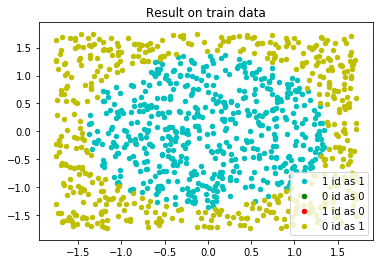

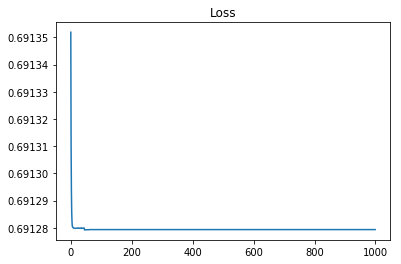

In [31]:
output = model_5.forward(train_input)
l = model_5.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")


id_class_train = output.argmax(dim=1)
plot_result(train_input, train_target, id_class_train)
plot_loss(range(0, epochs_number), my_loss_5)


 
Loss:  0.6932492256164551
Number of errors:  491

 


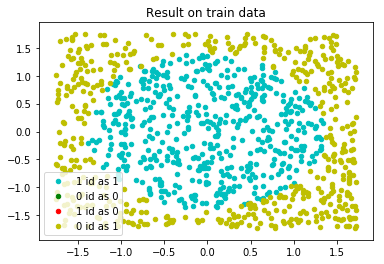

In [32]:
output = model_5.forward(test_input)
l = model_5.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")


id_class_test = output.argmax(dim=1)
plot_result(test_input, test_target, id_class_test)


## Model 6: Same as 1 but with MSE

In [23]:
hidden_nb = 25

linear_1 = Linear(2, hidden_nb)
relu_1 = Relu()
linear_2 = Linear(hidden_nb, hidden_nb)
relu_2 = Relu()
linear_3 = Linear(hidden_nb, hidden_nb)
relu_3 = Relu()
linear_4 = Linear(hidden_nb, 2)
loss = LossMSE()

model_6 = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=CrossEntropy()) 
       
std = 0.1
eta = 3e-1
batch_size = 200
epochs_number = 1000

my_loss_6 = []

model_6.normalize_parameters(mean=0, std=std)
optimizer = Sgd()

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model_6.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model_6.compute_loss(output, train_target.narrow(0, b, batch_size))
        model_6.backward()
        
        optimizer(model_6.sequence, eta=eta)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
    my_loss_6.append(loss_value.item())

0 :  0.6906421780586243
50 :  0.10838058590888977
100 :  0.06986785680055618
150 :  0.06643127650022507
200 :  0.049232177436351776
250 :  0.0659930408000946
300 :  0.04676635563373566
350 :  0.04388793930411339
400 :  0.044028930366039276
450 :  0.03770995885133743
500 :  0.040913693606853485
550 :  0.04042602330446243
600 :  0.029713744297623634
650 :  0.020620116963982582
700 :  0.019046630710363388
750 :  0.016392821446061134
800 :  0.016124267131090164
850 :  0.01689819246530533
900 :  0.01563171297311783
950 :  0.020614013075828552



 
Loss:  0.050098635256290436
Number of errors:  21

 


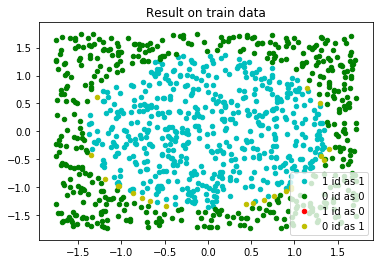

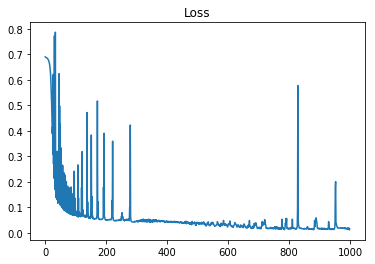

In [24]:
output = model_6.forward(train_input)
l = model_6.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")


id_class_train = output.argmax(dim=1)
plot_result(train_input, train_target, id_class_train)
plot_loss(range(0, epochs_number), my_loss_6)


 
Loss:  0.07188672572374344
Number of errors:  28

 


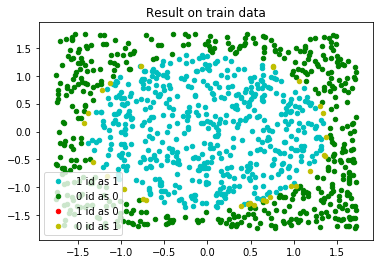

In [25]:
output = model_6.forward(test_input)
l = model_6.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")


id_class_test = output.argmax(dim=1)
plot_result(test_input, test_target, id_class_test)


## All graphs

Text(0.5,0,'Epochs')

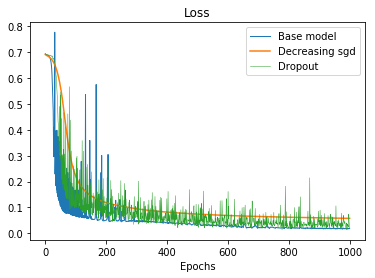

In [17]:

plt.plot(range(0, epochs_number), my_loss_1, linewidth=1)
plt.plot(range(0, epochs_number), my_loss_2)
plt.plot(range(0, epochs_number), my_loss_3,  linewidth=0.5)
plt.legend(["Base model", "Decreasing sgd", "Dropout"])
plt.title("Loss")
plt.xlabel("Epochs")

Text(0.5,0,'Epochs')

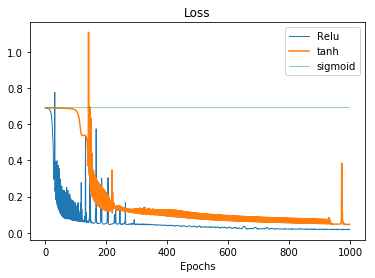

In [36]:

plt.plot(range(0, epochs_number), my_loss_1, linewidth=1)
plt.plot(range(0, epochs_number), my_loss_4)
plt.plot(range(0, epochs_number), my_loss_5,  linewidth=0.5)
plt.legend(["Relu", "tanh", "sigmoid"])
plt.title("Loss")
plt.xlabel("Epochs")